In [7]:
import pandas as pd

df = pd.read_csv('../data/NBA_2024_Shots.csv')

df.head()

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2024,2023-24,1610612764,Washington Wizards,1629673,Jordan Poole,G,SG,11-03-2023,22300003,...,In The Paint (Non-RA),Center,C,8-16 ft.,-0.4,17.45,12,1,11,1
1,2024,2023-24,1610612764,Washington Wizards,1630166,Deni Avdija,F,SF,11-03-2023,22300003,...,Above the Break 3,Center,C,24+ ft.,1.5,30.55,25,1,10,26
2,2024,2023-24,1610612764,Washington Wizards,1626145,Tyus Jones,G,PG,11-03-2023,22300003,...,Restricted Area,Center,C,Less Than 8 ft.,-3.3,6.55,3,1,9,46
3,2024,2023-24,1610612764,Washington Wizards,1629673,Jordan Poole,G,SG,11-03-2023,22300003,...,Restricted Area,Center,C,Less Than 8 ft.,-1.0,5.85,1,1,8,30
4,2024,2023-24,1610612764,Washington Wizards,1626145,Tyus Jones,G,PG,11-03-2023,22300003,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,6.25,1,1,8,8


In [8]:
df.columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218701 entries, 0 to 218700
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEASON_1        218701 non-null  int64  
 1   SEASON_2        218701 non-null  object 
 2   TEAM_ID         218701 non-null  int64  
 3   TEAM_NAME       218701 non-null  object 
 4   PLAYER_ID       218701 non-null  int64  
 5   PLAYER_NAME     218701 non-null  object 
 6   POSITION_GROUP  217437 non-null  object 
 7   POSITION        217437 non-null  object 
 8   GAME_DATE       218701 non-null  object 
 9   GAME_ID         218701 non-null  int64  
 10  HOME_TEAM       218701 non-null  object 
 11  AWAY_TEAM       218701 non-null  object 
 12  EVENT_TYPE      218701 non-null  object 
 13  SHOT_MADE       218701 non-null  bool   
 14  ACTION_TYPE     218701 non-null  object 
 15  SHOT_TYPE       218701 non-null  object 
 16  BASIC_ZONE      218701 non-null  object 
 17  ZONE_NAME 

In [9]:
#Clean and prepare the data
df_clean = df.dropna()

df_clean['SHOT_MADE'] = df_clean['SHOT_MADE'].astype(int)

df_clean['TIME_LEFT_SEC'] = df_clean['MINS_LEFT'] * 60 + df_clean['SECS_LEFT']

features = [
    'SHOT_TYPE', 'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_RANGE',
    'TIME_LEFT_SEC', 'POSITION'
]

target = 'SHOT_MADE'

df_model = df_clean[features + [target]]
df_model.head()

/var/folders/7m/pkc50zmj7pv5wx79cqth07ch0000gn/T/ipykernel_3366/3385549753.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['SHOT_MADE'] = df_clean['SHOT_MADE'].astype(int)
/var/folders/7m/pkc50zmj7pv5wx79cqth07ch0000gn/T/ipykernel_3366/3385549753.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['TIME_LEFT_SEC'] = df_clean['MINS_LEFT'] * 60 + df_clean['SECS_LEFT']


,SHOT_TYPE,ACTION_TYPE,BASIC_ZONE,ZONE_RANGE,TIME_LEFT_SEC,POSITION,SHOT_MADE
0,2PT Field Goal,Driving Floating Jump Shot,In The Paint (Non-RA),8-16 ft.,661,SG,0
1,3PT Field Goal,Jump Shot,Above the Break 3,24+ ft.,626,SF,1
2,2PT Field Goal,Driving Layup Shot,Restricted Area,Less Than 8 ft.,586,PG,1
3,2PT Field Goal,Running Finger Roll Layup Shot,Restricted Area,Less Than 8 ft.,510,SG,1
4,2PT Field Goal,Cutting Layup Shot,Restricted Area,Less Than 8 ft.,488,PG,1


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = df_model.drop('SHOT_MADE', axis=1)
y = df_model['SHOT_MADE']

categorical_cols = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[13973  8896]
 [10205 10414]]
              precision    recall  f1-score   support

           0       0.58      0.61      0.59     22869
           1       0.54      0.51      0.52     20619

    accuracy                           0.56     43488
   macro avg       0.56      0.56      0.56     43488
weighted avg       0.56      0.56      0.56     43488



In [11]:
# Get feature names from encoder + raw importances
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
feature_names = ohe.get_feature_names_out(categorical_cols)
all_features = list(feature_names) + ['TIME_LEFT_SEC']

importances = pipeline.named_steps['classifier'].feature_importances_

import pandas as pd
feat_imp = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feat_imp.head(10)

,feature,importance
74,TIME_LEFT_SEC,0.827933
55,BASIC_ZONE_Restricted Area,0.030372
52,BASIC_ZONE_In The Paint (Non-RA),0.010883
61,ZONE_RANGE_Less Than 8 ft.,0.010866
0,SHOT_TYPE_2PT Field Goal,0.009790
58,ZONE_RANGE_24+ ft.,0.009000
33,ACTION_TYPE_Running Dunk Shot,0.007594
4,ACTION_TYPE_Cutting Dunk Shot,0.006732
1,SHOT_TYPE_3PT Field Goal,0.006130
13,ACTION_TYPE_Driving Layup Shot,0.005797


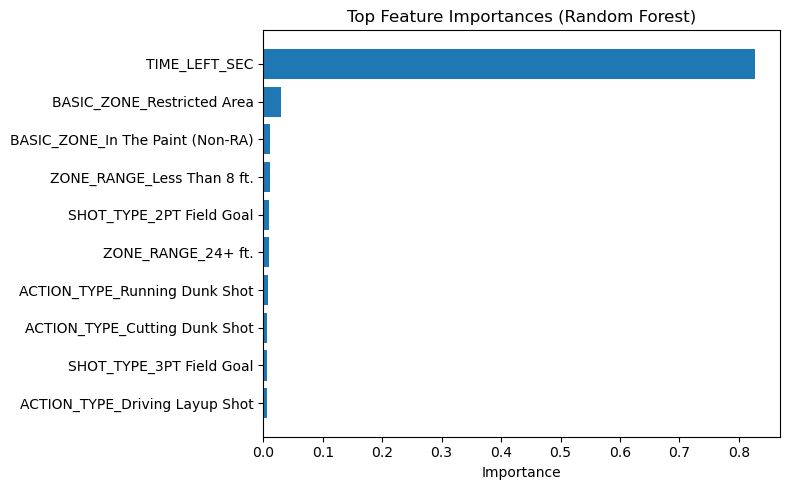

In [12]:
import matplotlib.pyplot as plt

top_n = 10
plt.figure(figsize=(8, 5))
plt.barh(feat_imp.head(top_n)['feature'], feat_imp.head(top_n)['importance'])
plt.gca().invert_yaxis()
plt.title('Top Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('../visuals/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
zone_stats = (
    df_clean.groupby('BASIC_ZONE')['SHOT_MADE']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

zone_stats

,BASIC_ZONE,SHOT_MADE
0,Restricted Area,0.663272
1,In The Paint (Non-RA),0.441003
2,Mid-Range,0.418760
3,Right Corner 3,0.393813
4,Left Corner 3,0.385734
5,Above the Break 3,0.359846
6,Backcourt,0.018519


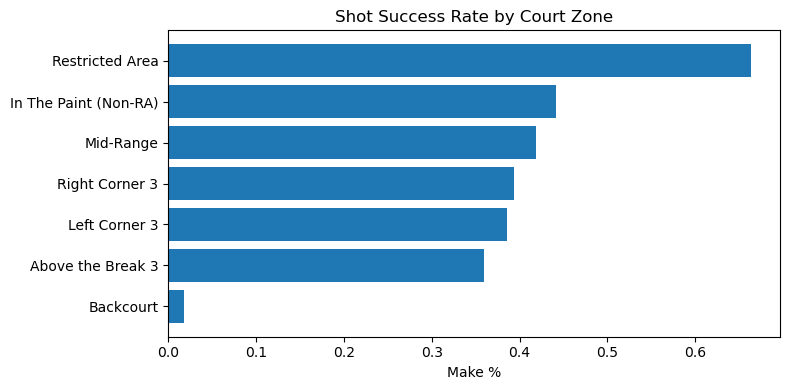

In [14]:
plt.figure(figsize=(8, 4))
plt.barh(zone_stats['BASIC_ZONE'], zone_stats['SHOT_MADE'])
plt.xlabel('Make %')
plt.title('Shot Success Rate by Court Zone')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../visuals/shot_success_by_zone.png', dpi=300, bbox_inches='tight')
plt.show()

### Summary of Findings

- **Model Performance:** The Random Forest classifier achieved ~56% accuracy. Precision and recall are balanced but relatively low.
- **Top Feature:** `TIME_LEFT_SEC` was by far the most important predictor of whether a shot was made.
- **Court Zone Insights:** Shots from the **Restricted Area** had the highest success rate (~66%), while **Backcourt** had the lowest (~2%).

These insights suggest timing and shot location are key drivers of success.